In [27]:
import numpy as np
from numpy.linalg import inv, cholesky, LinAlgError
from joblib import Parallel, delayed
import seaborn as sns
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

def omega_bootstrap(A, replicates=1000, samples_per_replicate=10000,
                    use_chol_decomp=False, n_jobs=-1, seed=None):
    """
    Estimates Omega(A): the proportion of feasible vectors within the unit sphere.
    Uses Monte Carlo sampling from N(0, Σ) and evaluates how many fall within the positive orthant.
    
    Parameters:
        A : np.ndarray
            Interaction matrix (SxS)
        replicates : int
            Number of independent estimates
        samples_per_replicate : int
            Number of samples per estimate
        use_chol_decomp : bool
            If True, uses Cholesky decomposition to invert AᵀA
        n_jobs : int
            Number of parallel processes to use
        seed : int or None
            Random seed for reproducibility
    
    Returns:
        np.ndarray
            Omega estimates (length = replicates)
    """
    A = np.array(A)
    S = A.shape[0]

    if A.shape[1] != S:
        raise ValueError("Matrix A should be square (SxS)")

    # Normalizar columnas de A para que estén en la esfera unitaria
    column_norms = np.linalg.norm(A, axis=0)
    if np.any(column_norms == 0):
        raise ValueError("Some columns are 0.")
    A = A / column_norms
    
    try:
        AtA = A.T @ A
        if use_chol_decomp:
            L = cholesky(AtA)
            Sigma = inv(L.T) @ inv(L)
        else:
            Sigma = inv(AtA)
    except LinAlgError:
        raise ValueError("Not inverse of AᵀA. Coul be non defined positive.")

    if seed is not None:
        np.random.seed(seed)

    # Factor de descomposición para muestreo
    L = cholesky(Sigma)

    def estimate():
        Z = np.random.randn(samples_per_replicate, S)  # muestras estándar
        X = Z @ L.T  # transformación para obtener covarianza Σ
        is_positive = (X > 0).all(axis=1)
        return np.mean(is_positive)

    results = Parallel(n_jobs=n_jobs)(delayed(estimate)() for _ in range(replicates))

    return np.array(results)


In [28]:
def calculateC(name):
    A = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,1:].astype(np.float64)
    B = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B.csv').to_numpy()[:,1:].astype(np.float64)
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()

    C = np.zeros((A.shape[0], A.shape[1], len(P)))
    for i,p in enumerate(P):
        C[:,:,i] = A + B*p[0]
    #C = A[:,:,np.newaxis] + B[:,:,np.newaxis] * P.T

    return -C
    
def calculateC_sd(name):
    A = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,1:].astype(np.float64)
    Asd = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A_sd.csv').to_numpy()[:,1:].astype(np.float64)
    
    B = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B.csv').to_numpy()[:,1:].astype(np.float64)
    Bsd = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B_sd.csv').to_numpy()[:,1:].astype(np.float64)
    
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()


    C = np.zeros((A.shape[0], A.shape[1], len(P)))
    Anew = np.random.normal(loc=A, scale=Asd)
    Bnew = np.random.normal(loc=B, scale=Bsd)
    
    for i,p in enumerate(P):
        C[:,:,i] = Anew + Bnew*p[0]

    """
    plt.scatter((np.random.normal(loc=A, scale=Asd)).flatten(), np.random.normal(loc=A, scale=0).flatten())
    plt.xlabel('Sd')
    plt.ylabel('0')
    plt.plot([np.min(A), np.max(A)],[np.min(A),np.max(A)],'--',color='gray')
    plt.show()
    """
    
    #C = np.random.normal(loc=A, scale=0)[:,:,np.newaxis] + np.random.normal(loc=B, scale=0)[:,:,np.newaxis] * P.T

    return -C

def giveP(name):
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
    return P.transpose()[0]

def calculateOmegas(C):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    for t in range(temporal):
        Omegas[t] = np.mean(omega_bootstrap(C[:,:,t], replicates=1000, samples_per_replicate=10000))
    return Omegas 

def plotOmegas(name,Omegas):
    plt.plot(Omegas)
    plt.scatter(range(len(Omegas)), Omegas, edgecolors='black',s=50)
    plt.title(name)
    plt.xlabel('Years')
    plt.ylabel('Feasibility Domain')
    plt.show()

In [29]:
OmegaCARACOLES = calculateOmegas(calculateC('CARACOLES'))
OmegaS_CARACOLES = []
for i in range(100):
    OmegaS_CARACOLES.append(calculateOmegas(calculateC_sd('CARACOLES')))
    if i % 10 == 0:
        print(i)
OmegaS_CARACOLES = np.array(OmegaS_CARACOLES)
OmegaS_CARACOLES

0
10
20
30
40
50
60
70
80
90


array([[1.176000e-04, 2.256600e-03, 4.440000e-05, 5.450000e-05,
        7.610000e-05, 1.166000e-04, 3.960000e-04, 6.277760e-02,
        1.331730e-02],
       [3.140000e-05, 1.466000e-04, 2.900000e-06, 9.900000e-06,
        2.842000e-04, 2.024000e-04, 1.623700e-03, 1.556710e-02,
        2.781180e-02],
       [5.725600e-03, 4.752300e-03, 2.382300e-03, 2.064700e-03,
        2.903080e-02, 2.186780e-02, 1.027067e-01, 6.282540e-02,
        6.662080e-02],
       [3.969000e-04, 3.280000e-05, 1.708000e-04, 1.042000e-04,
        1.629100e-03, 1.221200e-03, 7.509000e-03, 1.559247e-01,
        2.692398e-01],
       [3.227900e-03, 1.961100e-03, 1.768900e-03, 1.858400e-03,
        7.863300e-03, 6.867300e-03, 1.226020e-02, 5.419610e-02,
        3.318060e-02],
       [1.439400e-03, 1.786500e-03, 7.688000e-04, 5.249000e-04,
        5.326300e-03, 4.216200e-03, 1.376570e-02, 1.145310e-02,
        2.657510e-02],
       [1.147800e-03, 3.014500e-03, 2.135000e-04, 7.180000e-05,
        5.400400e-03, 4.055800

In [30]:
PCARACOLES = giveP('CARACOLES')
PCARACOLES

array([420.6, 625.5, 487.9, 533.2, 372.4, 379.1, 346.7, 225.2, 285.2])

In [31]:
dfOmegas_S_CARACOLES = pd.DataFrame()
for replica in range(OmegaS_CARACOLES.shape[0]):
    dfOmegas_S_CARACOLES[str(replica)] = OmegaS_CARACOLES[replica,:]
dfOmegas_S_CARACOLES['env'] = PCARACOLES

dfOmegas_S_CARACOLES = pd.melt(dfOmegas_S_CARACOLES, id_vars='env', var_name='replica', value_name='value')
dfOmegas_S_CARACOLES['replica'] = dfOmegas_S_CARACOLES['replica'].astype(int)
dfOmegas_S_CARACOLES

/var/folders/pn/ln92hbl56jj2m2mzfrm1cl4c0000gn/T/ipykernel_31985/1375689460.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfOmegas_S_CARACOLES['env'] = PCARACOLES


,env,replica,value
0,420.6,0,0.000118
1,625.5,0,0.002257
2,487.9,0,0.000044
3,533.2,0,0.000055
4,372.4,0,0.000076
...,...,...,...
895,372.4,99,0.000451
896,379.1,99,0.000317
897,346.7,99,0.001651
898,225.2,99,0.082675


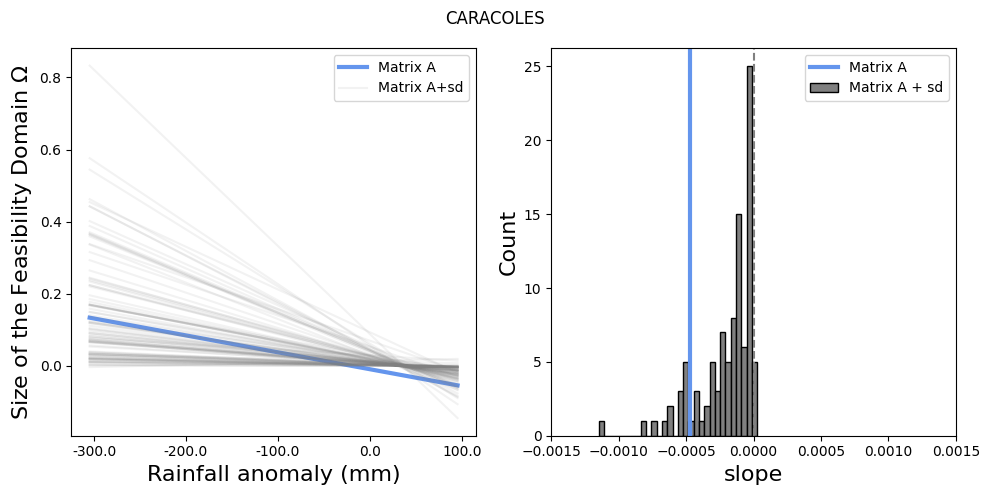

In [75]:
name = 'CARACOLES'
P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
P = P.transpose()[0]

Plabels = pd.read_csv('complexity72h-2025-main/data/'+name+'/rainfall_anomaly.csv')
Plabels = Plabels.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
Plabels = Plabels.transpose()[0]


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(PCARACOLES, OmegaCARACOLES)
plt.plot([np.min(P),np.max(P)],[np.min(P)*slope1+intercept1,np.max(P)*slope1+intercept1],linewidth=3,label='Matrix A',color='cornflowerblue')

Slopes = []

for u in dfOmegas_S_CARACOLES.groupby('replica'):
    slope, intercept, r_value, p_value, std_err = stats.linregress(u[1]['env'], u[1]['value'])
    plt.plot([np.min(P),np.max(P)],[intercept-np.min(P)*slope,np.max(P)*slope+intercept],alpha=0.1,color='gray', label='Matrix A+sd')
    Slopes.append(slope)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Crea un diccionario para eliminar duplicados
plt.legend(unique_labels.values(), unique_labels.keys())
plt.ylabel('Size of the Feasibility Domain '+r'$\Omega$', fontsize=16)
plt.xlabel('Rainfall anomaly (mm)',fontsize=16)
plt.xticks(ticks  = np.round(np.linspace(np.min(P),np.max(P),5),-1), 
           labels = np.round(np.linspace(np.min(Plabels),np.max(Plabels),5),-1),fontsize=10)
plt.yticks(fontsize=10)
#plt.title('CARACOLES')
#plt.show()

plt.subplot(1,2,2)

plt.axvline(x=slope1,color='cornflowerblue',label='Matrix A',linewidth=3)
plt.hist(Slopes,bins=30,color='gray',ec='black', label='Matrix A + sd',cumulative=0)

plt.axvline(x=0,color='gray',linestyle='--')


plt.xlim(-0.0015,0.0015)
plt.ylabel('Count',fontsize=16)
plt.xlabel('slope',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

plt.suptitle('CARACOLES')
plt.tight_layout()
plt.savefig('slopes_errors_CARACOLES.pdf')
plt.show()

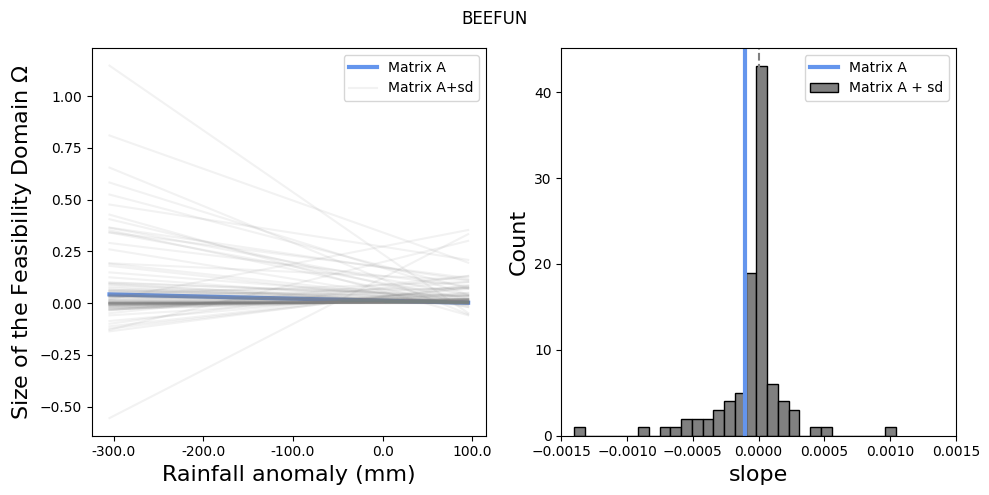

In [76]:
name = 'BEEFUN'
P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
P = P.transpose()[0]

Plabels = pd.read_csv('complexity72h-2025-main/data/'+name+'/rainfall_anomaly.csv')
Plabels = Plabels.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
Plabels = Plabels.transpose()[0]


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(PBEEFUN, OmegaBEEFUN)
plt.plot([np.min(P),np.max(P)],[np.min(P)*slope1+intercept1,np.max(P)*slope1+intercept1],linewidth=3,label='Matrix A',color='cornflowerblue')

Slopes = []

for u in dfOmegas_S_BEEFUN.groupby('replica'):
    slope, intercept, r_value, p_value, std_err = stats.linregress(u[1]['env'], u[1]['value'])
    plt.plot([np.min(P),np.max(P)],[intercept-np.min(P)*slope,np.max(P)*slope+intercept],alpha=0.1,color='gray', label='Matrix A+sd')
    Slopes.append(slope)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Crea un diccionario para eliminar duplicados
plt.legend(unique_labels.values(), unique_labels.keys())
plt.ylabel('Size of the Feasibility Domain '+r'$\Omega$', fontsize=16)
plt.xlabel('Rainfall anomaly (mm)',fontsize=16)
plt.xticks(ticks  = np.round(np.linspace(np.min(P),np.max(P),5),-1), 
           labels = np.round(np.linspace(np.min(Plabels),np.max(Plabels),5),-1),fontsize=10)
plt.yticks(fontsize=10)
#plt.title('CARACOLES')
#plt.show()

plt.subplot(1,2,2)

plt.axvline(x=slope1,color='cornflowerblue',label='Matrix A',linewidth=3)
plt.hist(Slopes,bins=30,color='gray',ec='black', label='Matrix A + sd',cumulative=0)

plt.axvline(x=0,color='gray',linestyle='--')


plt.xlim(-0.0015,0.0015)
plt.ylabel('Count',fontsize=16)
plt.xlabel('slope',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

plt.suptitle('BEEFUN')
plt.tight_layout()
plt.savefig('slopes_errors_BEEFUN.pdf')
plt.show()